In [1]:
# 导入相关依赖库
import os
import numpy as np
from matplotlib import pyplot as plt

import mindspore as ms
# context模块用于设置实验环境和实验设备
import mindspore.context as context
# dataset模块用于处理数据形成数据集
import mindspore.dataset as ds
# c_transforms模块用于转换数据类型
import mindspore.dataset.transforms.c_transforms as C
# vision.c_transforms模块用于转换图像，这是一个基于opencv的高级API
import mindspore.dataset.vision.c_transforms as CV
# 导入Accuracy作为评价指标
from mindspore.nn.metrics import Accuracy
# nn中有各种神经网络层如：Dense，ReLu
from mindspore import nn
# Model用于创建模型对象，完成网络搭建和编译，并用于训练和评估
from mindspore.train import Model
# LossMonitor可以在训练过程中返回LOSS值作为监控指标
from mindspore.train.callback import LossMonitor
# 设定运行模式为动态图模式，并且运行设备为昇腾芯片
context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')
# change for more function | shannon | 2022.11.17
# 用于记录训练时间
import time
# 用于进入训练看板
from mindspore.train.callback import SummaryCollector

In [2]:
# MindSpore内置方法读取MNIST数据集
ds_train = ds.MnistDataset(os.path.join(r'./MNIST', "train"))
ds_test = ds.MnistDataset(os.path.join(r'./MNIST', "test")) 

print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
# 该数据集可以通过create_dict_iterator()转换为迭代器形式，然后通过__next__()一个个输出样本
image=ds_train.create_dict_iterator().__next__()
print(type(image))
print('图像长/宽/通道数：',image['image'].shape)
# 一共10类，用0-9的数字表达类别。
print('一张图像的标签样式：',image['label'])

训练数据集数量： 60000
测试数据集数量： 10000
<class 'dict'>
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 2


In [3]:
DATA_DIR_TRAIN = "./MNIST/train" # 训练集信息
DATA_DIR_TEST = "./MNIST/test" # 测试集信息
def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    # 定义改变形状、归一化和更改图片维度的操作。
    # 改为（28,28）的形状
    resize_op = CV.Resize(resize)
    # rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    # 由高度、宽度、深度改为深度、高度、宽度
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    # 设定洗牌缓冲区的大小，从一定程度上控制打乱操作的混乱程度
    ds = ds.shuffle(buffer_size=buffer_size)
    # 设定数据集的batch_size大小，并丢弃剩余的样本
    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds

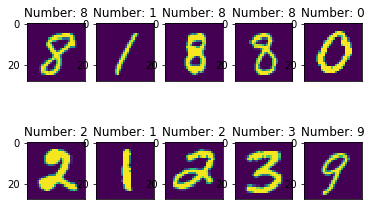

In [4]:
# 显示前10张图片以及对应标签,检查图片是否是正确的数据集
dataset_show = create_dataset(training=False)
data = dataset_show.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1,11):
    plt.subplot(2, 5, i)
    # 利用squeeze方法去掉多余的一个维度
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

In [5]:
# 利用定义类的方式生成网络，Mindspore中定义网络需要继承nn.cell。在init方法中定义该网络需要的神经网络层
# 在construct方法中梳理神经网络层与层之间的关系。
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)   
        output = self.fc4(output)
        output = self.fc5(output)
        output = self.fc6(output)
        return output

In [6]:
lr = 0.001      # learning rate
num_epoch = 20

net = ForwardNN()
# 定义loss函数，改函数不需要求导，可以给离散的标签值，且loss值为均值
loss = nn.loss.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
# 定义准确率为评价指标，用于评价模型
metrics={"Accuracy": Accuracy()}
# 定义优化器为Adam优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr) 

In [7]:
# 生成验证集，验证机不需要训练，所以不需要repeat
ds_eval = create_dataset(False, batch_size=32)
# 模型编译过程，将定义好的网络、loss函数、评价指标、优化器编译
model = Model(net, loss, opt, metrics)

# 生成训练集
# ds_train = create_dataset(True, batch_size=32)
ds_train = create_dataset(True, batch_size=128)
specified = {"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*", "collect_graph": True,"collect_dataset_graph": True}
summary_collector = SummaryCollector(summary_dir="./summary/summary_05", collect_specified_data=specified,collect_freq=1, keep_default_action=False, collect_tensor_freq=200)
print("============== Starting Training ==============")
start = time.clock()
# 训练模型，用loss作为监控指标，并利用昇腾芯片的数据下沉特性进行训练
model.train(num_epoch, ds_train,callbacks=[LossMonitor(),summary_collector],dataset_sink_mode=True)
end = time.clock()
print("============== Ending Training ==============")
print("running time: {}s".format(str(end-start)))
print("average epoch running time: {}s".format(str((end-start)/num_epoch)))

============== Starting Training ==============
epoch: 1 step: 468, loss is 2.2097229957580566
epoch: 2 step: 468, loss is 1.7475111484527588
epoch: 3 step: 468, loss is 1.554292917251587
epoch: 4 step: 468, loss is 1.5093796253204346
epoch: 5 step: 468, loss is 1.602241039276123
epoch: 6 step: 468, loss is 1.5259665250778198
epoch: 7 step: 468, loss is 1.5088175535202026
epoch: 8 step: 468, loss is 1.5317308902740479
epoch: 9 step: 468, loss is 1.524455189704895
epoch: 10 step: 468, loss is 1.5241199731826782
epoch: 11 step: 468, loss is 1.517235517501831
epoch: 12 step: 468, loss is 1.520277500152588
epoch: 13 step: 468, loss is 1.5487926006317139
epoch: 14 step: 468, loss is 1.5347946882247925
epoch: 15 step: 468, loss is 1.562770128250122
epoch: 16 step: 468, loss is 1.499806523323059
epoch: 17 step: 468, loss is 1.484597086906433
epoch: 18 step: 468, loss is 1.4927257299423218
epoch: 19 step: 468, loss is 1.4999632835388184
epoch: 20 step: 468, loss is 1.5016047954559326
=========

In [8]:
# 使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)

{'Accuracy': 0.9353966346153846}


In [9]:
%reload_ext mindinsight
%mindinsight --port 30000 --summary-base-dir ./summary/

Launching MindInsight in Notebook...

[INFO] MI(3404:281472891983744,MainProcess):2022-11-23-09:45:55.289.208 [mindinsight/modelarts/notebook.py:180][NOTEBOOK] Reusing MindInsight on port 30000. (pid 1295, Use "mindinsight stop --port 30000" to stop it.) Web address: http://127.0.0.1:30000
